In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
df_ratings=pd.read_csv("toy_dataset.csv",index_col=0)
df_ratings.head()

,action1,action2,action3,romantic1,romantic2,romantic3
user 1,4.0,5.0,3.0,NaN,2.0,1.0
user 2,5.0,3.0,3.0,2.0,2.0,NaN
user 3,1.0,NaN,NaN,4.0,5.0,4.0
user 4,NaN,2.0,1.0,4.0,NaN,3.0
user 5,1.0,NaN,2.0,3.0,3.0,4.0


In [3]:
df_ratings.fillna(0, inplace=True)
df_ratings

,action1,action2,action3,romantic1,romantic2,romantic3
user 1,4.0,5.0,3.0,0.0,2.0,1.0
user 2,5.0,3.0,3.0,2.0,2.0,0.0
user 3,1.0,0.0,0.0,4.0,5.0,4.0
user 4,0.0,2.0,1.0,4.0,0.0,3.0
user 5,1.0,0.0,2.0,3.0,3.0,4.0


In [4]:
df_ratings.describe()

,action1,action2,action3,romantic1,romantic2,romantic3
count,5.000000,5.00000,5.00000,5.00000,5.00000,5.00000
mean,2.200000,2.00000,1.80000,2.60000,2.40000,2.40000
std,2.167948,2.12132,1.30384,1.67332,1.81659,1.81659
min,0.000000,0.00000,0.00000,0.00000,0.00000,0.00000
25%,1.000000,0.00000,1.00000,2.00000,2.00000,1.00000
50%,1.000000,2.00000,2.00000,3.00000,2.00000,3.00000
75%,4.000000,3.00000,3.00000,4.00000,3.00000,4.00000
max,5.000000,5.00000,3.00000,4.00000,5.00000,4.00000


in other for the model created from this data to be applicable in other dataset scenarios, standardation is very important.

In [5]:
def standardize(row):
    new_row = (row - row.mean())/(row.max()-row.min())
    return new_row

df_std = df_ratings.apply(standardize).T
print(df_std)

           user 1  user 2  user 3    user 4    user 5
action1      0.36    0.56   -0.24 -0.440000 -0.240000
action2      0.60    0.20   -0.40  0.000000 -0.400000
action3      0.40    0.40   -0.60 -0.266667  0.066667
romantic1   -0.65   -0.15    0.35  0.350000  0.100000
romantic2   -0.08   -0.08    0.52 -0.480000  0.120000
romantic3   -0.35   -0.60    0.40  0.150000  0.400000


In [6]:
sparse_df = sparse.csr_matrix(df_std.values)

In [7]:
#Create a dataframe from the sparse matrix using the df_ratings index and columns
corrMatrix = pd.DataFrame(cosine_similarity(sparse_df),index=df_ratings.columns,columns=df_ratings.columns)
corrMatrix

,action1,action2,action3,romantic1,romantic2,romantic3
action1,1.000000,0.706689,0.813682,-0.799411,-0.025392,-0.914106
action2,0.706689,1.000000,0.723102,-0.845154,-0.518999,-0.843374
action3,0.813682,0.723102,1.000000,-0.847946,-0.379980,-0.802181
romantic1,-0.799411,-0.845154,-0.847946,1.000000,0.148039,0.723747
romantic2,-0.025392,-0.518999,-0.379980,0.148039,1.000000,0.393939
romantic3,-0.914106,-0.843374,-0.802181,0.723747,0.393939,1.000000


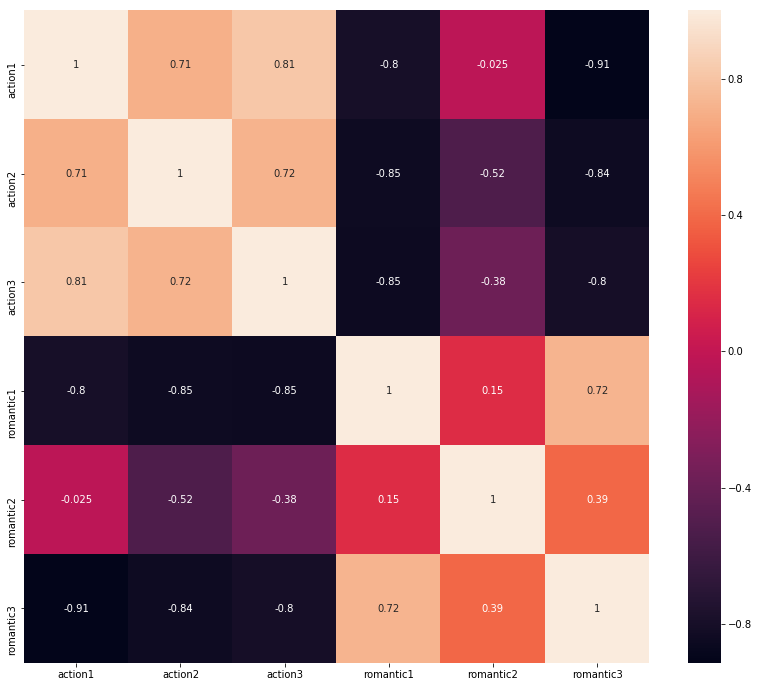

In [8]:
corr = df_ratings.corr()
plt.figure(figsize=(14,12))
sns.heatmap(corr, annot=True, fmt=".2g")

In [9]:
#Making Recommendations
def similar_movies(movie_name,df_ratings):
    similar_score = corrMatrix[movie_name]*(df_ratings) #we get a similarity score for all the movie that are similar to that movie
    similar_score = similar_score.sort_values(ascending=False) #then we scale it by the ratings the user has given to that movie
    return similar_score

In [10]:
print(similar_movies('action1',5))

action1      5.000000
action3      4.068408
action2      3.533444
romantic2   -0.126959
romantic1   -3.997054
romantic3   -4.570530
Name: action1, dtype: float64


In [11]:
print(similar_movies('romantic2',1))

romantic2    1.000000
romantic3    0.393939
romantic1    0.148039
action1     -0.025392
action3     -0.379980
action2     -0.518999
Name: romantic2, dtype: float64


In [12]:
def similar_movies_2(movie_name,rating):
    similar_score = corrMatrix[movie_name]*(rating-2.5)
    similar_score = similar_score.sort_values(ascending=False)

    return similar_score

In [13]:
print(similar_movies_2('romantic2',1))

action2      0.778499
action3      0.569970
action1      0.038088
romantic1   -0.222059
romantic3   -0.590909
romantic2   -1.500000
Name: romantic2, dtype: float64


In [14]:
action_lover = [("action2",5),('romantic1',1),('romantic3',1)]
similar_scores = pd.DataFrame()
for movie,rating in action_lover:
    similar_scores = similar_scores.append(similar_movies_2(movie,rating),ignore_index = True)

similar_scores.head()

,action1,action2,action3,romantic1,romantic2,romantic3
0,1.766722,2.500000,1.807754,-2.112886,-1.297498,-2.108435
1,1.199116,1.267731,1.271919,-1.500000,-0.222059,-1.085620
2,1.371159,1.265061,1.203271,-1.085620,-0.590909,-1.500000


In [15]:
similar_scores.sum().sort_values(ascending=False)

action2      5.032792
action1      4.336997
action3      4.282944
romantic2   -2.110466
romantic3   -4.694055
romantic1   -4.698506
dtype: float64

*Let's see how well this can perform on a real world data

In [16]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')
ratings = pd.merge(movies,ratings).drop(['genres','timestamp'],axis=1)
print(ratings.shape)
ratings.head()

(100836, 4)


,movieId,title,userId,rating
0,1,Toy Story (1995),1,4.0
1,1,Toy Story (1995),5,4.0
2,1,Toy Story (1995),7,4.5
3,1,Toy Story (1995),15,2.5
4,1,Toy Story (1995),17,4.5


In [17]:
userRatings = ratings.pivot_table(index=['userId'],columns=['title'],values='rating')
userRatings.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
userRatings = userRatings.dropna(thresh=10, axis=1).fillna(0,axis=1)
userRatings.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
corrMatrix = userRatings.corr(method='pearson')
corrMatrix.head()

title,"'burbs, The (1989)",(500) Days of Summer (2009),10 Cloverfield Lane (2016),10 Things I Hate About You (1999),"10,000 BC (2008)",101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),12 Years a Slave (2013),127 Hours (2010),...,Zack and Miri Make a Porno (2008),Zero Dark Thirty (2012),Zero Effect (1998),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016),eXistenZ (1999),xXx (2002),¡Three Amigos! (1986)
title,,,,,,,,,,,,,,,,,,,,,
"'burbs, The (1989)",1.000000,0.063117,-0.023768,0.143482,0.011998,0.087931,0.224052,0.034223,0.009277,0.008331,...,0.017477,0.032470,0.134701,0.153158,0.101301,0.049897,0.003233,0.187953,0.062174,0.353194
(500) Days of Summer (2009),0.063117,1.000000,0.142471,0.273989,0.193960,0.148903,0.142141,0.159756,0.135486,0.200135,...,0.374515,0.178655,0.068407,0.414585,0.355723,0.252226,0.216007,0.053614,0.241092,0.125905
10 Cloverfield Lane (2016),-0.023768,0.142471,1.000000,-0.005799,0.112396,0.006139,-0.016835,0.031704,-0.024275,0.272943,...,0.242663,0.099059,-0.023477,0.272347,0.241751,0.195054,0.319371,0.177846,0.096638,0.002733
10 Things I Hate About You (1999),0.143482,0.273989,-0.005799,1.000000,0.244670,0.223481,0.211473,0.011784,0.091964,0.043383,...,0.243118,0.104858,0.132460,0.091853,0.158637,0.281934,0.050031,0.121029,0.130813,0.110612
"10,000 BC (2008)",0.011998,0.193960,0.112396,0.244670,1.000000,0.234459,0.119132,0.059187,-0.025882,0.089328,...,0.260261,0.087592,0.094913,0.184521,0.242299,0.240231,0.094773,0.088045,0.203002,0.083518


In [20]:
romantic_lover = [("(500) Days of Summer (2009)",5),("Alice in Wonderland (2010)",3),("Aliens (1986)",1),("2001: A Space Odyssey (1968)",2)]
similar_movies = pd.DataFrame()
for movie,rating in romantic_lover:
    similar_movies = similar_movies.append(similar_movies_2(movie,rating),ignore_index = True)

similar_movies.sum().sort_values(ascending=False)

(500) Days of Summer (2009)               2.584556
Alice in Wonderland (2010)                1.395229
Silver Linings Playbook (2012)            1.254800
Yes Man (2008)                            1.116264
Adventureland (2009)                      1.112235
                                            ...   
Star Trek II: The Wrath of Khan (1982)   -0.841468
2001: A Space Odyssey (1968)             -0.866982
Hunt for Red October, The (1990)         -0.871453
Alien (1979)                             -1.034068
Aliens (1986)                            -1.605801
Length: 2269, dtype: float64